In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [7]:
def get_data(mydata, section, starttime, endtime):
    density = mydata.final_dens[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return density, transports

In [13]:
def get_all_data_SoG(folder):
    starttime = 1
    endtime = 720

    density = np.array([])
    transports = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

                density = np.append(density, tempD)
                transports = np.append(transports, tempT/720)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                density = np.append(density, mydata.final_dens[(mydata.final_section==section)])
                transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/forward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

            density = np.append(density, tempD)
            transports = np.append(transports, tempT/720)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return density, transports, month

In [41]:
back_mo = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']

def BACK_get_all_data_SoG(folder):
    starttime = 721
    endtime = 1440

    density = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0
    
    #2016 (month by month)
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'16/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            density = np.append(density, mydata.final_dens[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2017 and 2018
    k=12
    year = [17,18,19,20]
    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

                density = np.append(density, tempD)
                transports = np.append(transports, tempT/720)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k+=12
    
    return density, transports, month

In [3]:
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
# int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

In [15]:
month_edge = np.arange(0.5,61.5,1)
dens_edge = np.linspace(dens.mean()-dens.std()*3.5,dens.mean()+dens.std()*3,101)

Text(0, 0.5, 'Density (kg/m3)')

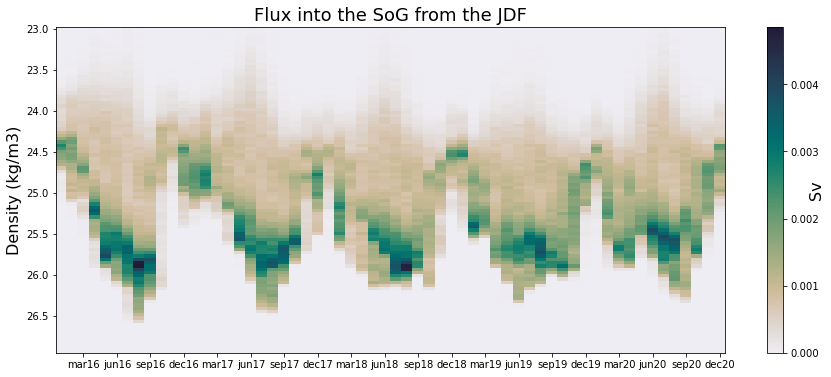

In [36]:
#DENSITY of FLUX
folder = '1hr'
dens, transports, month = get_all_data_SoG(folder)

transports = transports * (10**-6) #Convert to Sv

H1, xedges1, yedges1 = np.histogram2d(month, dens, bins=[month_edge,dens_edge], weights= transports, density=False)
H_final= H1.T #* H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges1, yedges1)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, cmap=cmap)
# im = ax.pcolormesh(X, Y, H_final, vmax=vmax, vmin=0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_label('Sv', labelpad=-10, fontsize = 16)

ax.invert_yaxis()
# ax.set_ylim((280, 0))
ax.set_title('Flux into the SoG from the JDF', fontsize = 18)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Density (kg/m3)', fontsize = 16)

Text(0, 0.5, 'Density (kg/m3)')

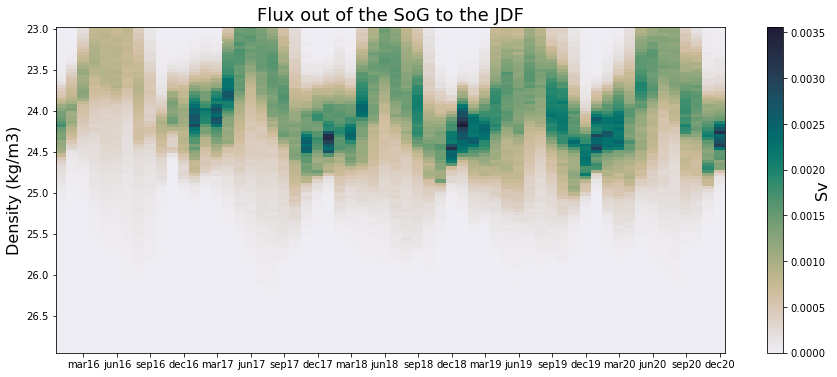

In [42]:
#DENSITY of FLUX
folder = '1hr'
dens, transports, month = BACK_get_all_data_SoG(folder)

transports = transports * (10**-6) #Convert to Sv

H1, xedges1, yedges1 = np.histogram2d(month, dens, bins=[month_edge,dens_edge], weights= transports, density=False)
H_final= H1.T #* H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges1, yedges1)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, cmap=cmap)
# im = ax.pcolormesh(X, Y, H_final, vmax=vmax, vmin=0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_label('Sv', labelpad=-10, fontsize = 16)

ax.invert_yaxis()
# ax.set_ylim((280, 0))
ax.set_title('Flux out of the SoG to the JDF', fontsize = 18)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Density (kg/m3)', fontsize = 16)